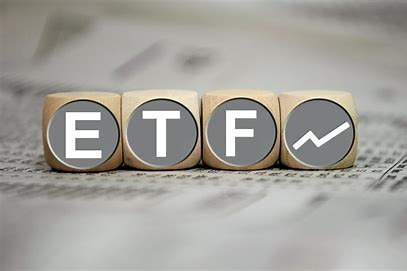

# First code project by Anton Kruse

Welcome to my first own project including python code. This project seeks to give an overview of the largest ETFs provided by the most common ETF suppliers. Personally, I invest small amounts into ETF since the beginning of 2018. Now, I would like to examine, if my choices have been evolved as good as the picked ETF. Furthermore, the scope tries to shed some light into optimal weighting approaches, such that, this notebook tries to perform several optimization methods. Finally, I would like to simulate different portfolio values, if I would have invested monthly a certain amount.

This notebook is only personal motivated and will certainly lack at many point. Diversification will not be covered, since picking the largest ETFs according to their Net Assets does not include any deaper strategy.

In [26]:
# import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import yfinance as yf
from matplotlib import dates
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
import jupyterthemes as jt
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme

In [27]:
# set_nb_theme('grade3')
!jt -t oceans16 -T

### Iternary for this project?

Step 1: Load the data.

Step 2: Give an overview about the data and the performance.

Step 3: Perform portfolio optimization.

Step 4: Create an interactive dashboard for clean presentation.

### Explaination of the ETFs for deaper understanding & better comparison

IVV: iShares Core S&P 500 ETF

IEFA: iShares Core MSCI EAFE ETF (Europe, Australasia, Far East)

AGG: iShares Core U.S. Aggregate Bond ETF (fixed income securities)

IJR: iShares Core S&P Small-Cap ETF 

SPX.MI: Lyxor S&P 500 UCITS ETF

WLDC.MI: Lyxor MSCI World UCITS ETF Acc

USRI.PA: Amundi Index Solutions - Amundi MSCI USA SRI UCITS ETF (track the performance of MSCI USA SRI Filtered ex Fossil Fuels 
Index)

MEUD.PA: Lyxor Core STOXX Europe 600

URTH: iShares MSCI World ETF

AEEM.PA: Amundi Index Solutions - Amundi MSCI Emerging Markets 

IUHE.AS: iShares V PLC - iShares S&P 500 Health Care Sector UCITS ETF

ICOM.L: iShares Diversified Commodity Swap UCITS ETF

In [28]:
# Step 1 - importing data by defining a for loop that gets the tickers from a list
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime.today()

ticker_ishares = ['IVV', 'IEFA', 'AGG', 'IJR']
ticker_amundi = ['SPX.MI', 'WLDC.MI', 'USRI.PA', 'MEUD.PA'] 
antons_ticker = ['URTH', 'AEEM.PA', 'IUHE.AS', 'ICOM.L']
data_ishares = pd.DataFrame(columns=ticker_ishares)
data_amundi = pd.DataFrame(columns=ticker_amundi)
antons_data = pd.DataFrame(columns=antons_ticker)

for i in ticker_ishares:
    data_ishares[i] = yf.download(i, start, end)['Adj Close']
for i in ticker_amundi:
    data_amundi[i] = yf.download(i, start, end)['Adj Close']
for i in antons_ticker:
    antons_data[i] = yf.download(i, start, end)['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Iternary for Step 2:
1. Descriptive statistic
2. Plot absolute & relative change over time
3. Show key facts for every ETF

In [29]:
# Step 2- descriptive statistic of the data set
data = [data_ishares, data_amundi, antons_data]

for i in data:
    print('This shows the descriptive statistics for {}'.format(i.columns))
    describe = i.describe().transpose()
    display(np.round(describe, 2))

This shows the descriptive statistics for Index(['IVV', 'IEFA', 'AGG', 'IJR'], dtype='object')


,count,mean,std,min,25%,50%,75%,max
IVV,1230.0,332.86,72.19,214.95,267.15,312.73,401.24,474.32
IEFA,1230.0,60.20,7.38,40.19,55.37,57.91,66.60,75.18
AGG,1230.0,104.97,6.79,93.42,98.00,105.85,111.80,114.53
IJR,1230.0,85.33,16.41,47.15,72.99,79.85,102.63,118.39


This shows the descriptive statistics for Index(['SPX.MI', 'WLDC.MI', 'USRI.PA', 'MEUD.PA'], dtype='object')


,count,mean,std,min,25%,50%,75%,max
SPX.MI,1241.0,31.09,6.51,21.28,25.43,29.14,38.03,43.40
WLDC.MI,357.0,10.95,0.43,9.88,10.64,10.86,11.30,11.84
USRI.PA,1064.0,69.32,15.48,44.04,55.91,65.96,84.50,98.10
MEUD.PA,1241.0,166.73,21.42,114.63,150.79,159.16,185.72,212.45


This shows the descriptive statistics for Index(['URTH', 'AEEM.PA', 'IUHE.AS', 'ICOM.L'], dtype='object')


,count,mean,std,min,25%,50%,75%,max
URTH,1230.0,99.44,18.12,64.65,83.38,94.42,115.43,134.88
AEEM.PA,1220.0,4.41,0.47,3.16,4.07,4.28,4.80,5.48
IUHE.AS,612.0,6.22,0.52,5.00,5.82,6.35,6.61,7.20
ICOM.L,1206.0,5.51,1.09,3.72,4.87,5.16,6.00,8.65


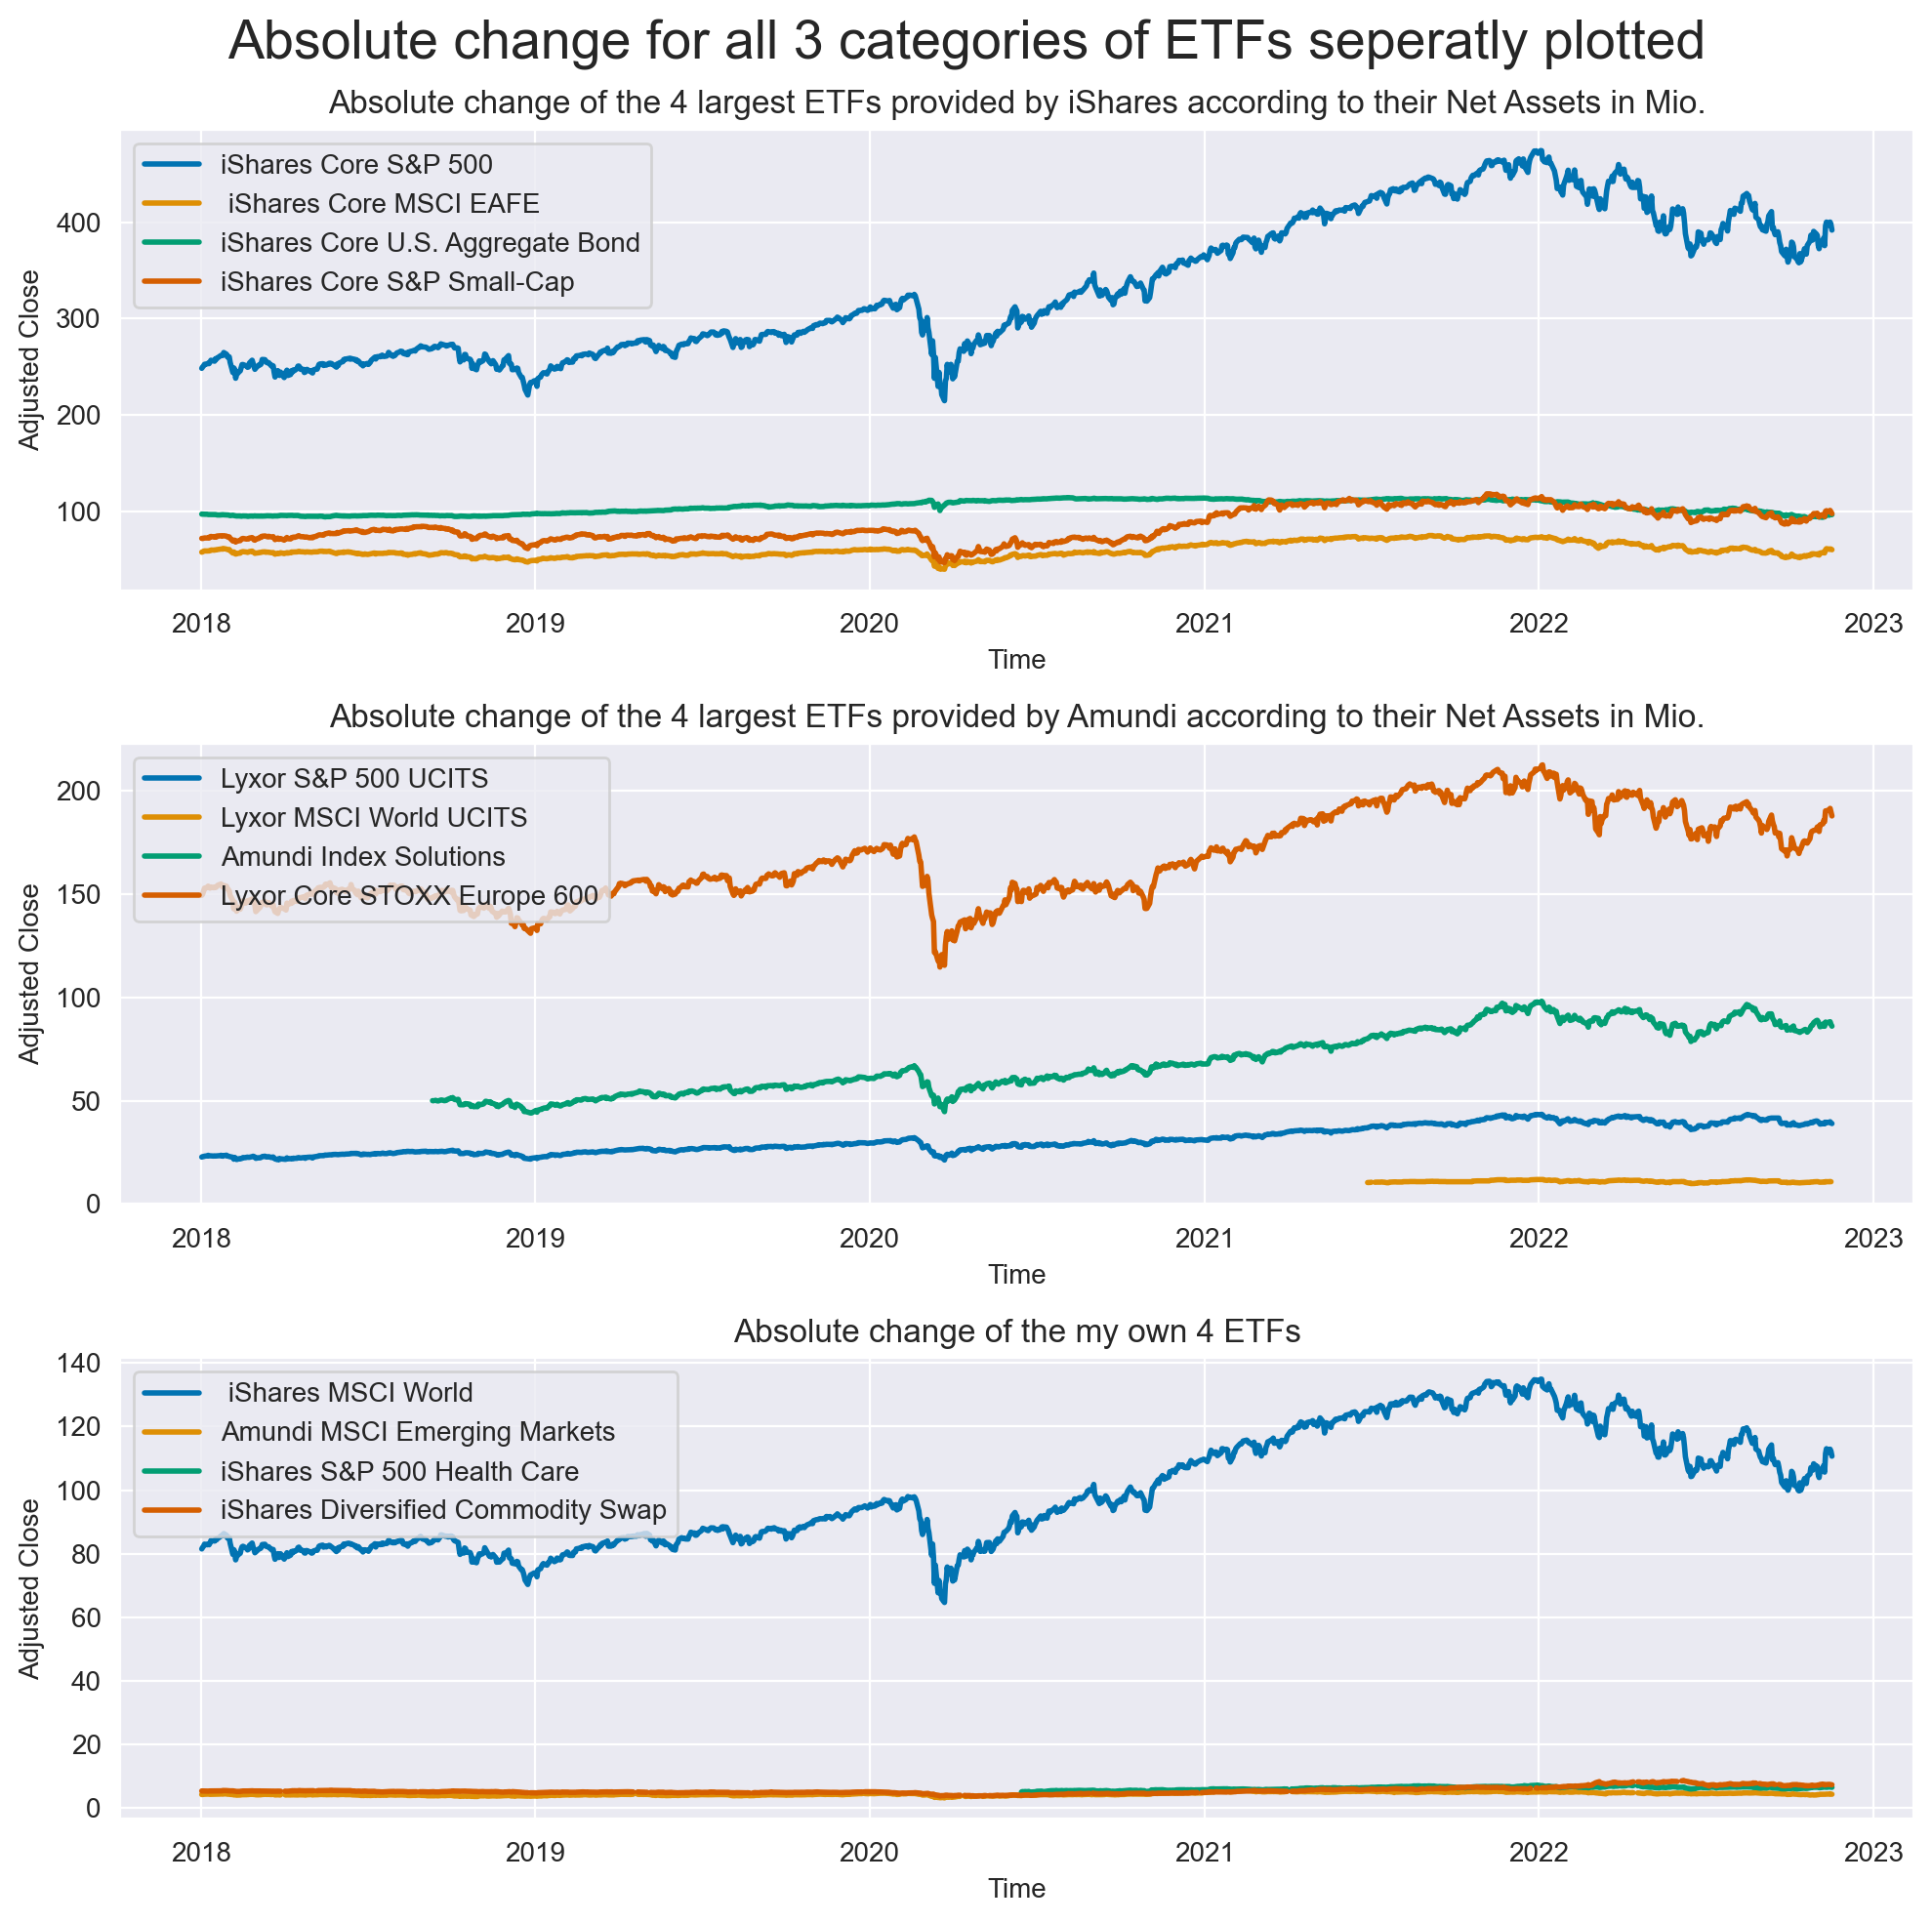

In [30]:
# plotting the absolute change over time for the data
# set style
sns.set_style('darkgrid')
sns.set_palette('colorblind')

fig, ax = plt.subplots(figsize=(10,10), dpi=200, nrows= 3)

ax[0].plot(data_ishares['IVV'], label="iShares Core S&P 500", lw=2)
ax[0].plot(data_ishares['IEFA'], label=" iShares Core MSCI EAFE", lw=2)
ax[0].plot(data_ishares['AGG'], label="iShares Core U.S. Aggregate Bond",lw=2)
ax[0].plot(data_ishares['IJR'], label="iShares Core S&P Small-Cap",lw=2)

ax[1].plot(data_amundi['SPX.MI'], label="Lyxor S&P 500 UCITS", lw=2)
ax[1].plot(data_amundi['WLDC.MI'], label="Lyxor MSCI World UCITS", lw=2)
ax[1].plot(data_amundi['USRI.PA'], label="Amundi Index Solutions",lw=2)
ax[1].plot(data_amundi['MEUD.PA'], label="Lyxor Core STOXX Europe 600",lw=2)

ax[2].plot(antons_data['URTH'], label=" iShares MSCI World", lw=2)
ax[2].plot(antons_data['AEEM.PA'], label="Amundi MSCI Emerging Markets", lw=2)
ax[2].plot(antons_data['IUHE.AS'], label="iShares S&P 500 Health Care",lw=2)
ax[2].plot(antons_data['ICOM.L'], label="iShares Diversified Commodity Swap",lw=2)

ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[2].set_xlabel('Time')
ax[0].set_ylabel('Adjusted Close')
ax[1].set_ylabel('Adjusted Close')
ax[2].set_ylabel('Adjusted Close')


ax[0].set_title('Absolute change of the 4 largest ETFs provided by iShares according to their Net Assets in Mio.')
ax[1].set_title('Absolute change of the 4 largest ETFs provided by Amundi according to their Net Assets in Mio.')
ax[2].set_title('Absolute change of the my own 4 ETFs')

fig.suptitle('Absolute change for all 3 categories of ETFs seperatly plotted', fontsize=20)

ax[0].xaxis.set_major_locator(dates.YearLocator())
ax[0].xaxis.set_major_formatter(dates.DateFormatter("%Y"))
ax[0].tick_params(axis="x", which="major",rotation=0, pad=5)

ax[1].xaxis.set_major_locator(dates.YearLocator())
ax[1].xaxis.set_major_formatter(dates.DateFormatter("%Y"))
ax[1].tick_params(axis="x", which="major",rotation=0, pad=5)

ax[2].xaxis.set_major_locator(dates.YearLocator())
ax[2].xaxis.set_major_formatter(dates.DateFormatter("%Y"))
ax[2].tick_params(axis="x", which="major",rotation=0, pad=5)

ax[0].legend(loc ='upper left')
ax[1].legend(loc = 'upper left')
ax[2].legend(loc = 'upper left')

plt.tight_layout()
plt.show();

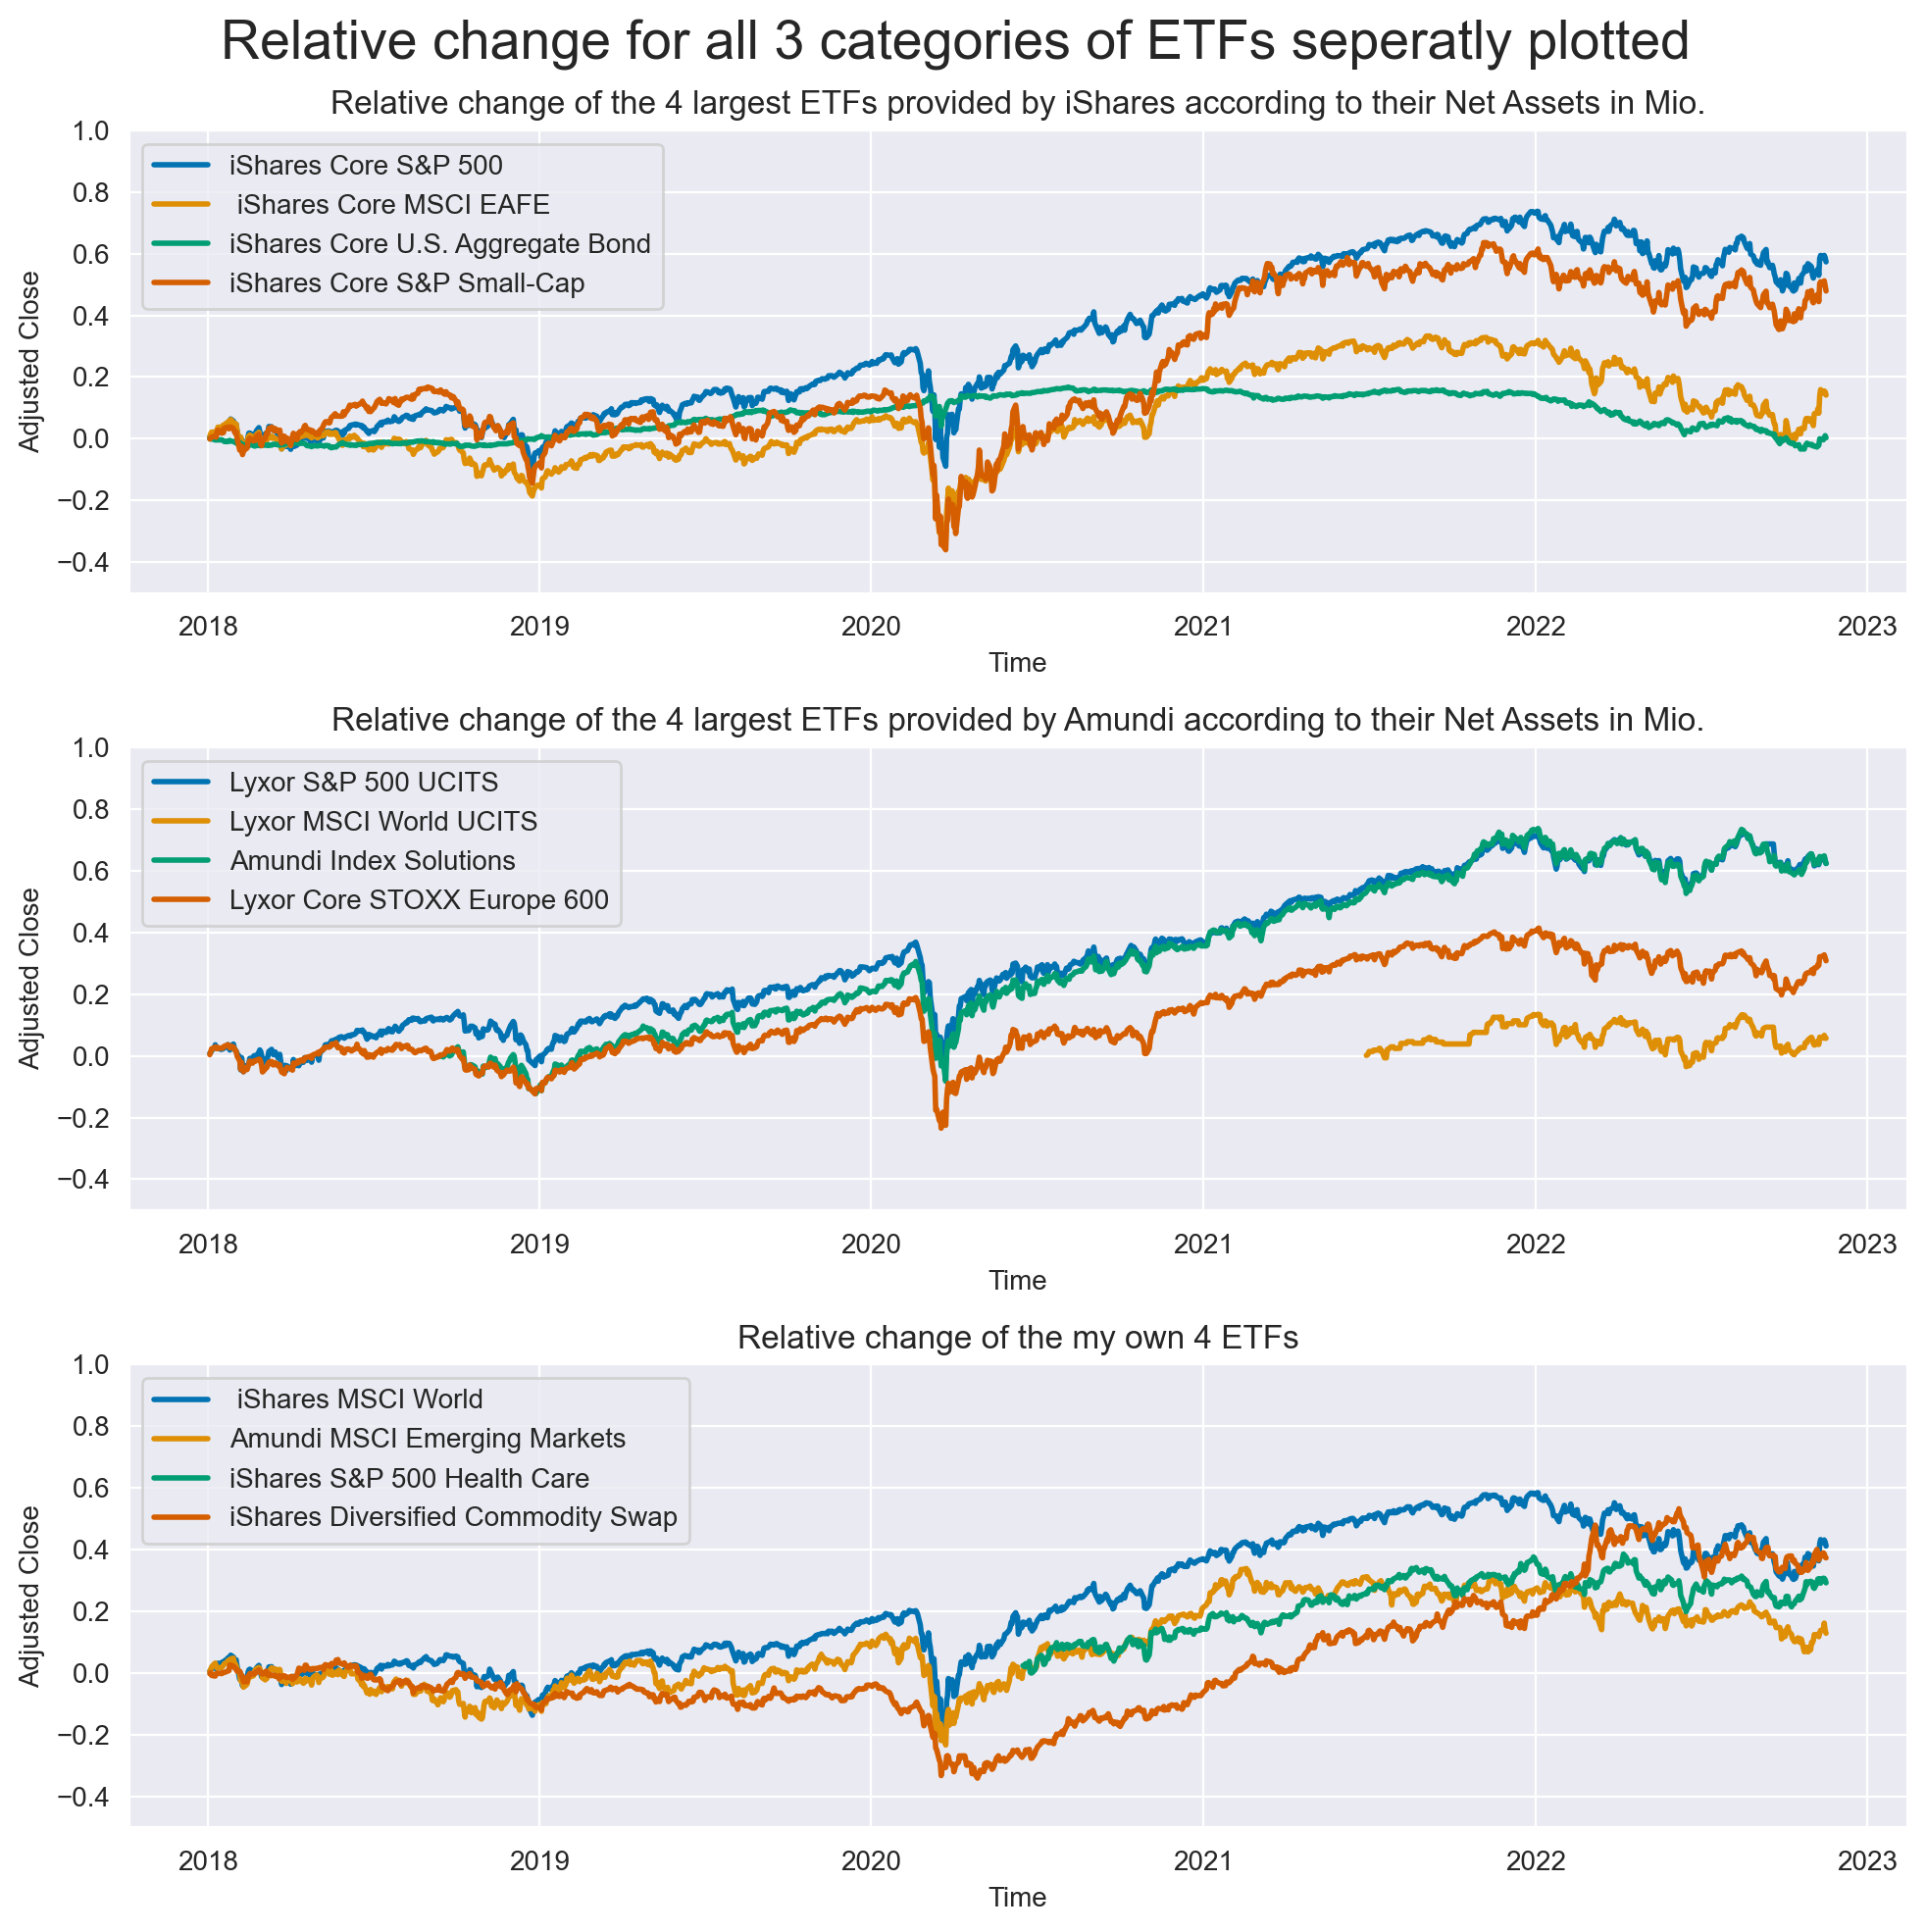

In [31]:
# plotting the relative change over time for the data
# set style
sns.set_style('darkgrid')
sns.set_palette('colorblind')

fig, ax = plt.subplots(figsize=(10,10), dpi=200, nrows= 3)

ax[0].plot(data_ishares['IVV'].pct_change().cumsum(), label="iShares Core S&P 500", lw=2)
ax[0].plot(data_ishares['IEFA'].pct_change().cumsum(), label=" iShares Core MSCI EAFE", lw=2)
ax[0].plot(data_ishares['AGG'].pct_change().cumsum(), label="iShares Core U.S. Aggregate Bond",lw=2)
ax[0].plot(data_ishares['IJR'].pct_change().cumsum(), label="iShares Core S&P Small-Cap",lw=2)

ax[1].plot(data_amundi['SPX.MI'].pct_change().cumsum(), label="Lyxor S&P 500 UCITS", lw=2)
ax[1].plot(data_amundi['WLDC.MI'].pct_change().cumsum(), label="Lyxor MSCI World UCITS", lw=2)
ax[1].plot(data_amundi['USRI.PA'].pct_change().cumsum(), label="Amundi Index Solutions",lw=2)
ax[1].plot(data_amundi['MEUD.PA'].pct_change().cumsum(), label="Lyxor Core STOXX Europe 600",lw=2)

ax[2].plot(antons_data['URTH'].pct_change().cumsum(), label=" iShares MSCI World", lw=2)
ax[2].plot(antons_data['AEEM.PA'].pct_change().cumsum(), label="Amundi MSCI Emerging Markets", lw=2)
ax[2].plot(antons_data['IUHE.AS'].pct_change().cumsum(), label="iShares S&P 500 Health Care",lw=2)
ax[2].plot(antons_data['ICOM.L'].pct_change().cumsum(), label="iShares Diversified Commodity Swap",lw=2)

ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[2].set_xlabel('Time')
ax[0].set_ylabel('Adjusted Close')
ax[1].set_ylabel('Adjusted Close')
ax[2].set_ylabel('Adjusted Close')


ax[0].set_title('Relative change of the 4 largest ETFs provided by iShares according to their Net Assets in Mio.')
ax[1].set_title('Relative change of the 4 largest ETFs provided by Amundi according to their Net Assets in Mio.')
ax[2].set_title('Relative change of the my own 4 ETFs')

fig.suptitle('Relative change for all 3 categories of ETFs seperatly plotted', fontsize=20)

ax[0].xaxis.set_major_locator(dates.YearLocator())
ax[0].xaxis.set_major_formatter(dates.DateFormatter("%Y"))
ax[0].tick_params(axis="x", which="major",rotation=0, pad=5)

ax[1].xaxis.set_major_locator(dates.YearLocator())
ax[1].xaxis.set_major_formatter(dates.DateFormatter("%Y"))
ax[1].tick_params(axis="x", which="major",rotation=0, pad=5)

ax[2].xaxis.set_major_locator(dates.YearLocator())
ax[2].xaxis.set_major_formatter(dates.DateFormatter("%Y"))
ax[2].tick_params(axis="x", which="major",rotation=0, pad=5)

ax[0].set_ylim((-0.5,1))
ax[1].set_ylim((-0.5,1))
ax[2].set_ylim((-0.5,1))

ax[0].legend(loc ='upper left')
ax[1].legend(loc = 'upper left')
ax[2].legend(loc = 'upper left')

plt.tight_layout()
plt.show();

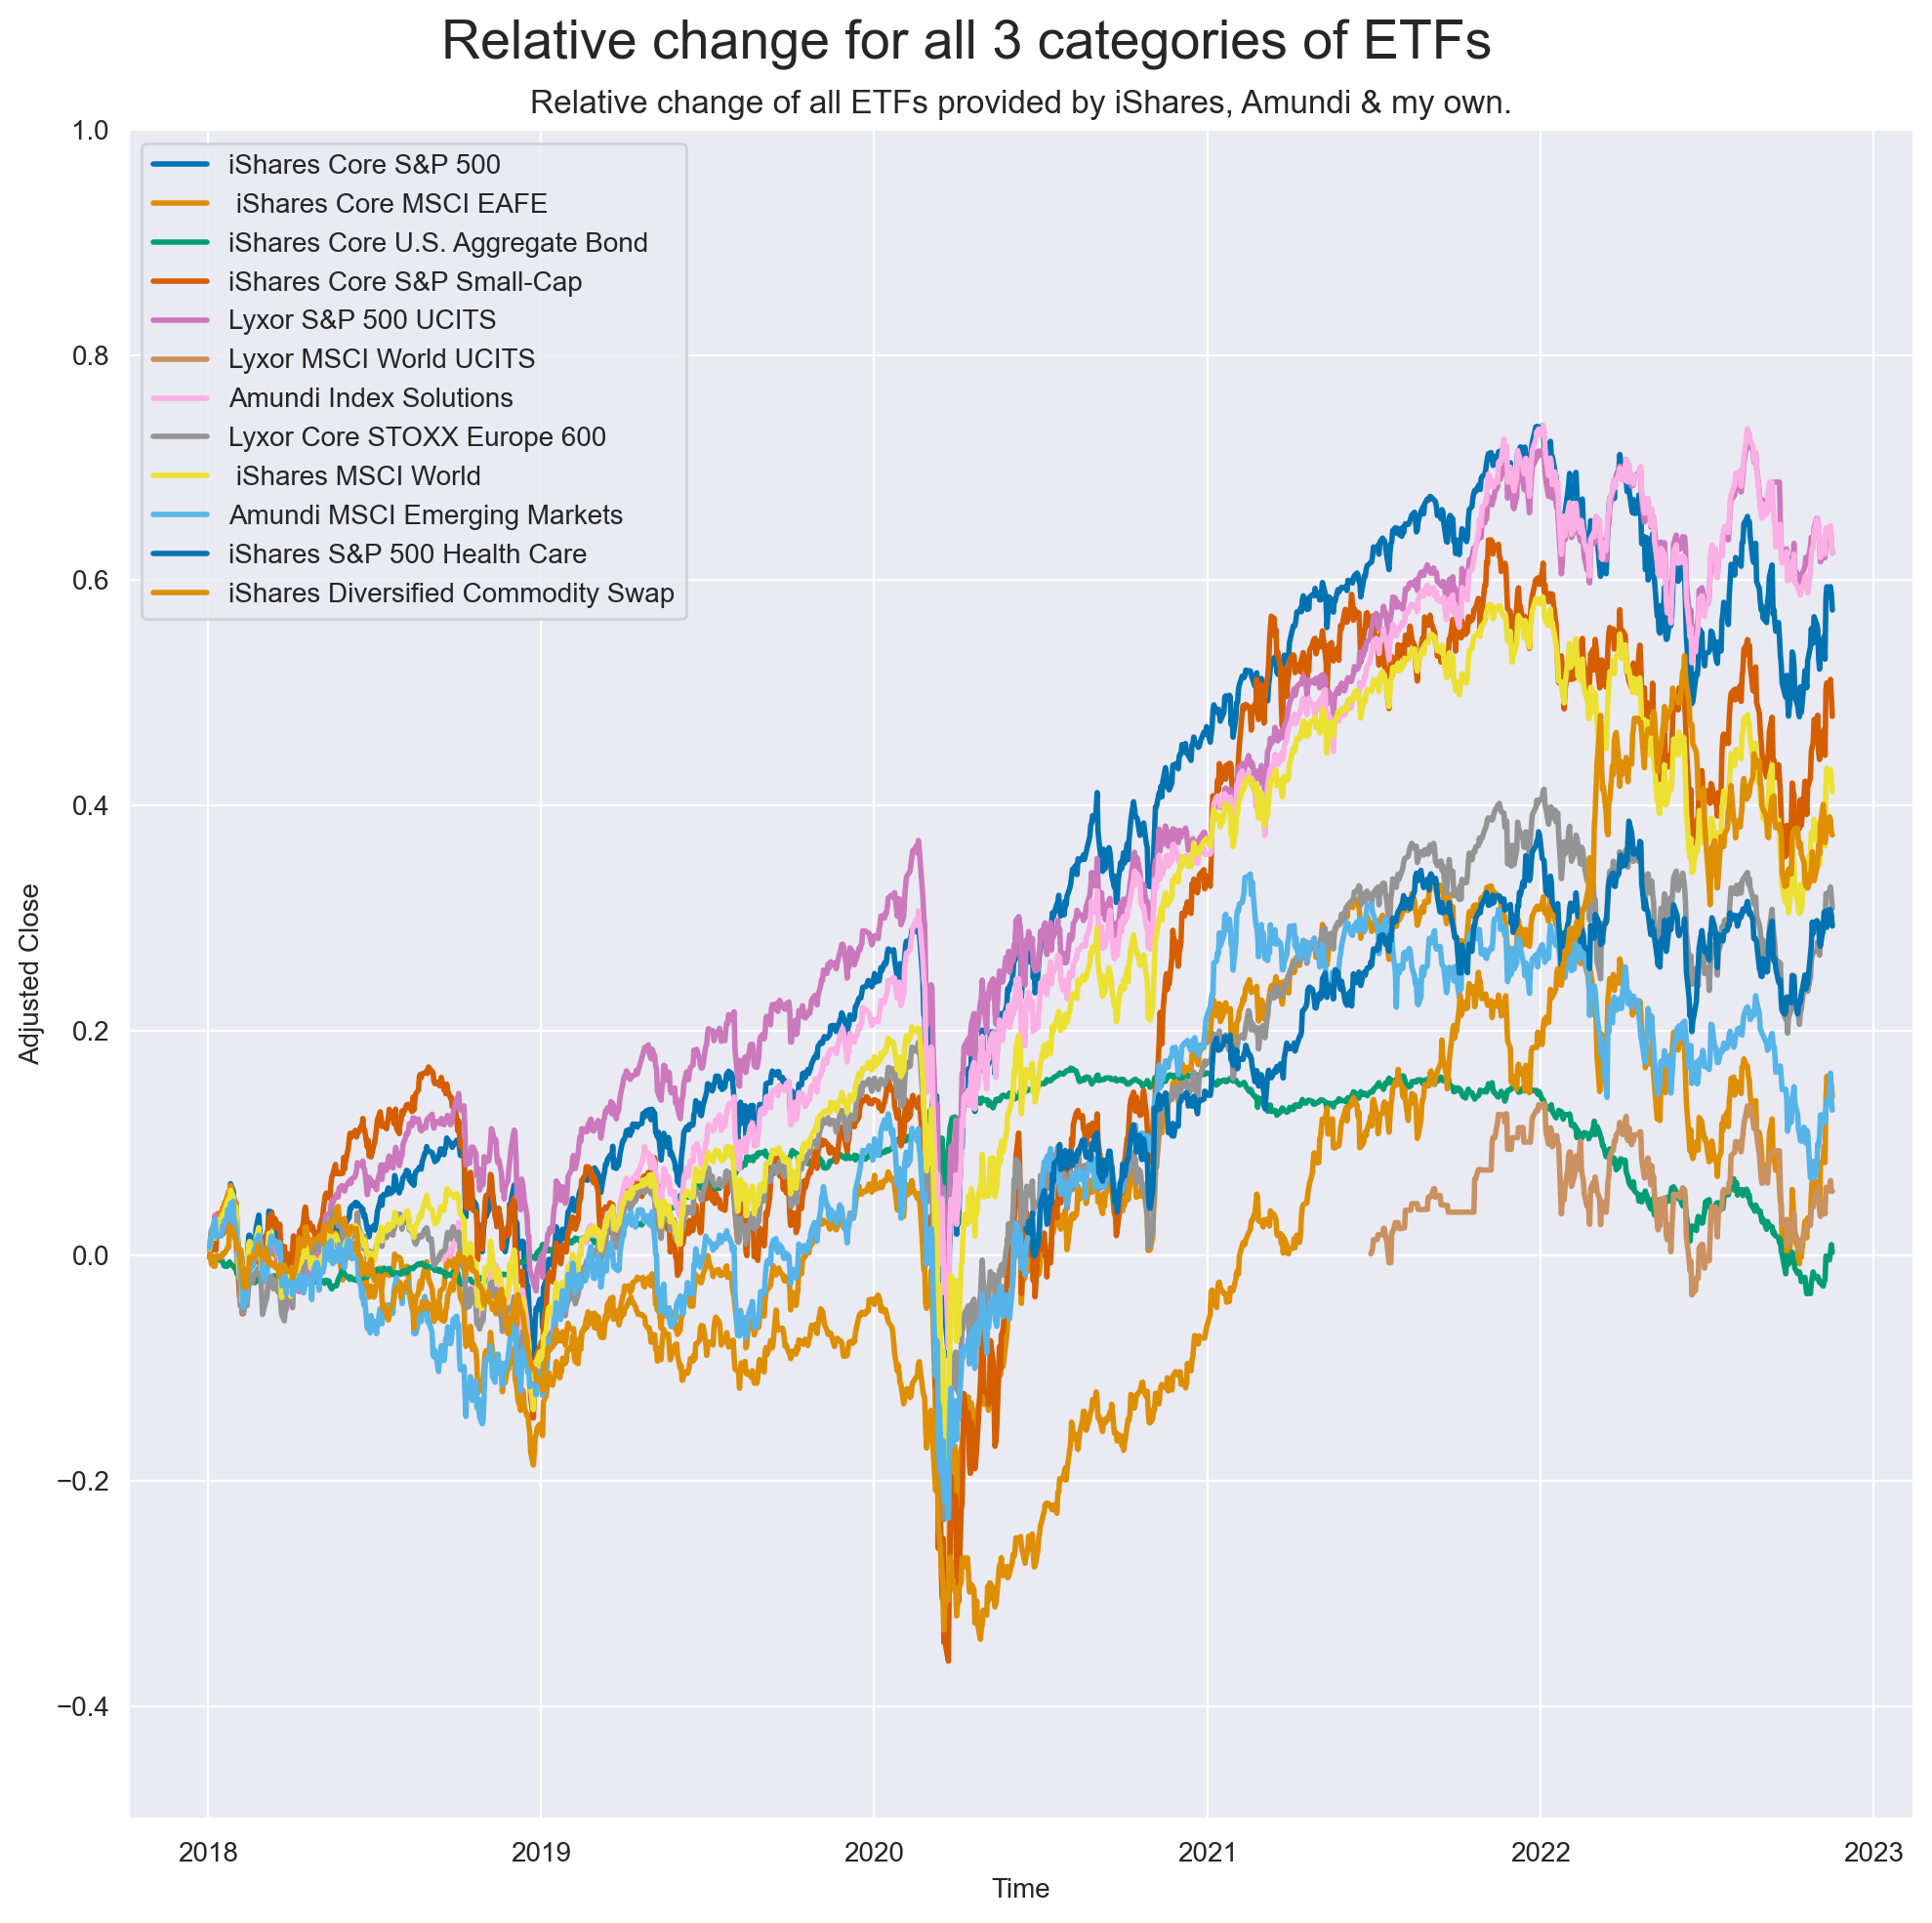

In [32]:
# put everything into one graph
# plotting the relative change over time for the data
# set style
sns.set_style('darkgrid')
sns.set_palette('colorblind')

fig, ax = plt.subplots(figsize=(10,10), dpi=200)

ax.plot(data_ishares['IVV'].pct_change().cumsum(), label="iShares Core S&P 500", lw=2)
ax.plot(data_ishares['IEFA'].pct_change().cumsum(), label=" iShares Core MSCI EAFE", lw=2)
ax.plot(data_ishares['AGG'].pct_change().cumsum(), label="iShares Core U.S. Aggregate Bond",lw=2)
ax.plot(data_ishares['IJR'].pct_change().cumsum(), label="iShares Core S&P Small-Cap",lw=2)

ax.plot(data_amundi['SPX.MI'].pct_change().cumsum(), label="Lyxor S&P 500 UCITS", lw=2)
ax.plot(data_amundi['WLDC.MI'].pct_change().cumsum(), label="Lyxor MSCI World UCITS", lw=2)
ax.plot(data_amundi['USRI.PA'].pct_change().cumsum(), label="Amundi Index Solutions",lw=2)
ax.plot(data_amundi['MEUD.PA'].pct_change().cumsum(), label="Lyxor Core STOXX Europe 600",lw=2)

ax.plot(antons_data['URTH'].pct_change().cumsum(), label=" iShares MSCI World", lw=2)
ax.plot(antons_data['AEEM.PA'].pct_change().cumsum(), label="Amundi MSCI Emerging Markets", lw=2)
ax.plot(antons_data['IUHE.AS'].pct_change().cumsum(), label="iShares S&P 500 Health Care",lw=2)
ax.plot(antons_data['ICOM.L'].pct_change().cumsum(), label="iShares Diversified Commodity Swap",lw=2)

ax.set_xlabel('Time')
ax.set_ylabel('Adjusted Close')

ax.set_title('Relative change of all ETFs provided by iShares, Amundi & my own.')

fig.suptitle('Relative change for all 3 categories of ETFs', fontsize=20)

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y"))
ax.tick_params(axis="x", which="major",rotation=0, pad=5)

ax.set_ylim((-0.5,1))

plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show();

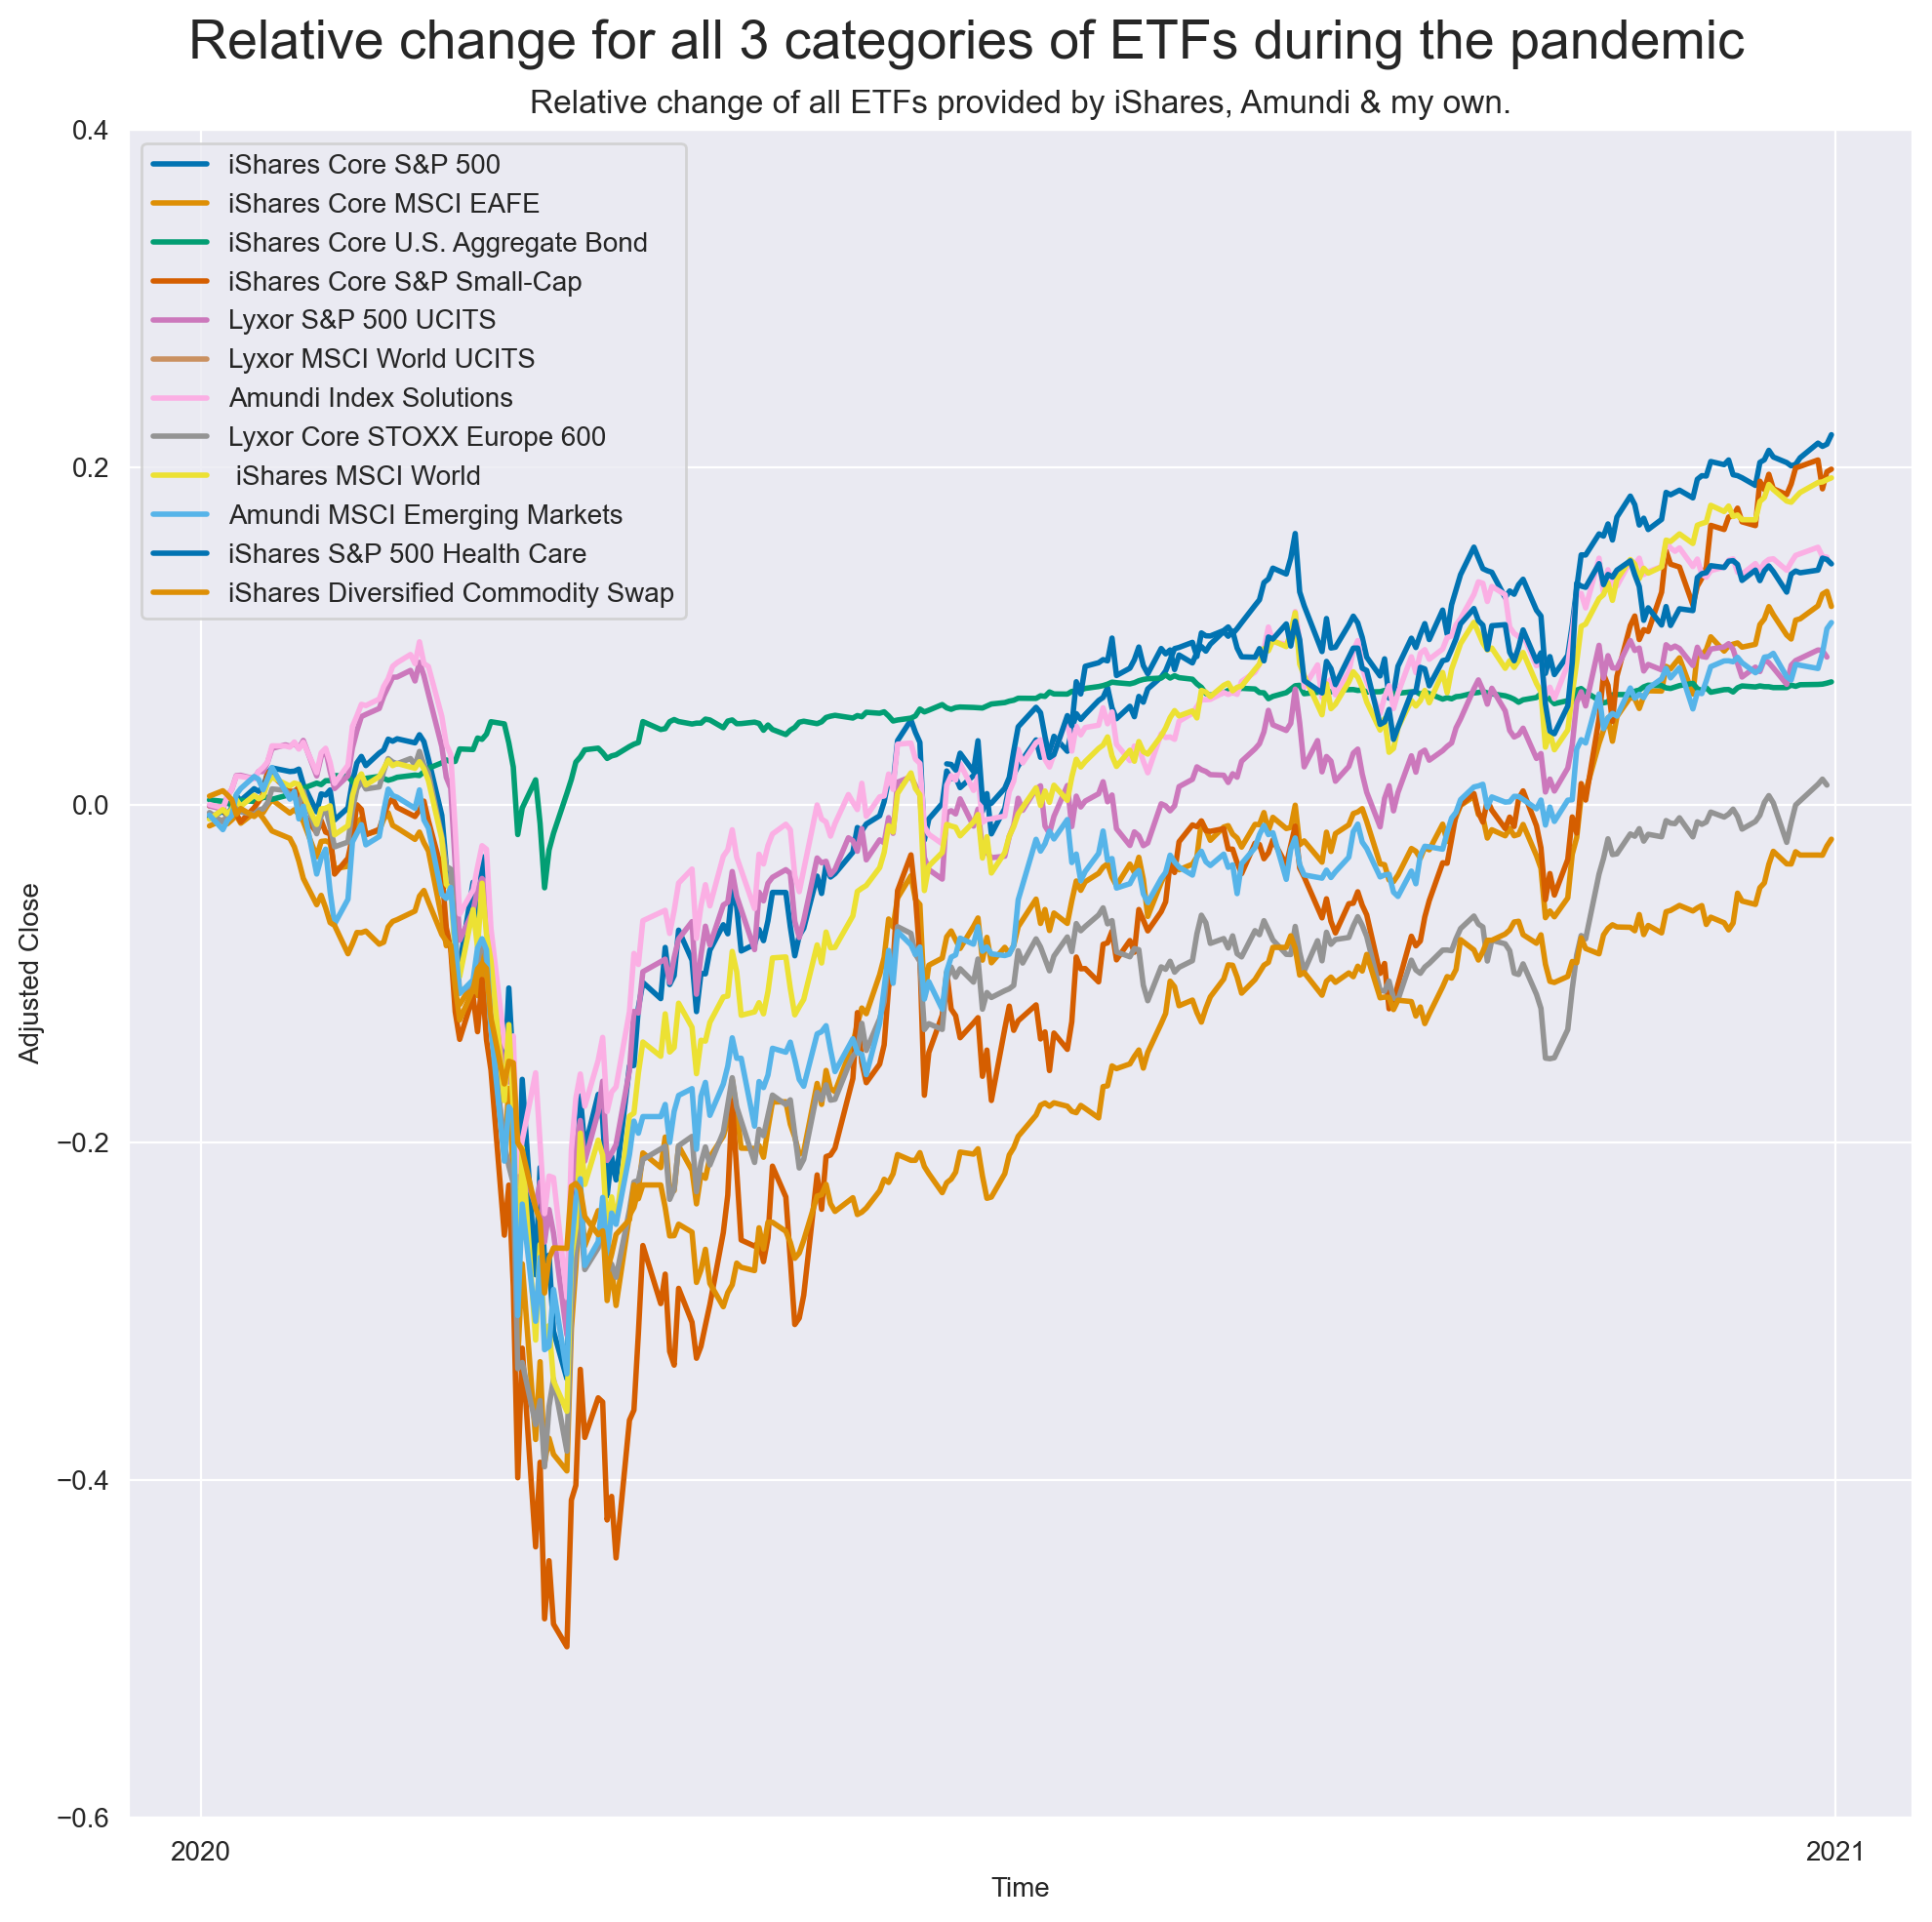

In [33]:
# get a visible idea how these ETFs are correlated by focus on the development during the pandemic
sns.set_style('darkgrid')
sns.set_palette('colorblind')

fig, ax = plt.subplots(figsize=(10,10), dpi=200)

ax.plot(data_ishares['IVV']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label="iShares Core S&P 500", lw=2)
ax.plot(data_ishares['IEFA']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label="iShares Core MSCI EAFE", lw=2)
ax.plot(data_ishares['AGG']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label="iShares Core U.S. Aggregate Bond",lw=2)
ax.plot(data_ishares['IJR']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label="iShares Core S&P Small-Cap",lw=2)

ax.plot(data_amundi['SPX.MI']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label="Lyxor S&P 500 UCITS", lw=2)
ax.plot(data_amundi['WLDC.MI']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label="Lyxor MSCI World UCITS", lw=2)
ax.plot(data_amundi['USRI.PA']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label="Amundi Index Solutions",lw=2)
ax.plot(data_amundi['MEUD.PA']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label="Lyxor Core STOXX Europe 600",lw=2)

ax.plot(antons_data['URTH']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label=" iShares MSCI World", lw=2)
ax.plot(antons_data['AEEM.PA']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label="Amundi MSCI Emerging Markets", lw=2)
ax.plot(antons_data['IUHE.AS']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label="iShares S&P 500 Health Care",lw=2)
ax.plot(antons_data['ICOM.L']["2020-01-01":"2021-01-01"].pct_change().cumsum(), label="iShares Diversified Commodity Swap",lw=2)

ax.set_xlabel('Time')
ax.set_ylabel('Adjusted Close')

ax.set_title('Relative change of all ETFs provided by iShares, Amundi & my own.')

fig.suptitle('Relative change for all 3 categories of ETFs during the pandemic', fontsize=20)

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y"))
ax.tick_params(axis="x", which="major",rotation=0, pad=5)

ax.set_ylim((-0.6,0.4))

plt.legend()
plt.tight_layout()
plt.show();

The zoomed graphs shows quite clearly, that the ETFs behave similarly. To get a furter insight into the behavior, we will have a look on their correlation.

In [34]:
# FINISH WHEN AMUNDI IS INCLUDED
all_data1 = data_ishares.merge(data_amundi, on="Date")
all_data = all_data1.merge(antons_data, on='Date')
all_data.head()

,IVV,IEFA,AGG,IJR,SPX.MI,WLDC.MI,USRI.PA,MEUD.PA,URTH,AEEM.PA,IUHE.AS,ICOM.L
Date,,,,,,,,,,,,
2018-01-02,248.559174,57.914581,97.355858,72.191902,22.719999,NaN,NaN,149.320007,81.489586,4.2190,NaN,5.34
2018-01-03,249.999939,58.297379,97.364769,72.126587,22.920000,NaN,NaN,149.940002,81.976051,4.2489,NaN,5.33
2018-01-04,251.082764,58.871567,97.302330,72.322495,22.965000,NaN,NaN,151.339996,82.343208,4.2604,NaN,5.35
2018-01-05,252.670349,59.176060,97.239906,72.630333,23.129999,NaN,NaN,152.820007,82.994888,4.3045,NaN,5.30
2018-01-08,253.230240,59.132557,97.213150,72.742271,23.309999,NaN,NaN,153.089996,82.792961,4.3472,NaN,5.29


In [35]:
# Show the correlation
corr = all_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,IVV,IEFA,AGG,IJR,SPX.MI,WLDC.MI,USRI.PA,MEUD.PA,URTH,AEEM.PA,IUHE.AS,ICOM.L
IVV,1.000000,0.848764,0.541463,0.905778,0.967456,0.736020,0.963799,0.949429,0.991433,0.865406,0.940503,0.671619
IEFA,0.848764,1.000000,0.497745,0.911556,0.720804,0.430857,0.749101,0.884537,0.909887,0.944237,0.623256,0.480199
AGG,0.541463,0.497745,1.000000,0.296076,0.413692,0.331887,0.244444,0.394712,0.556285,0.532121,-0.317240,-0.194545
IJR,0.905778,0.911556,0.296076,1.000000,0.854571,0.621248,0.862424,0.935989,0.930929,0.893551,0.839417,0.713796
SPX.MI,0.967456,0.720804,0.413692,0.854571,1.000000,0.942488,0.997065,0.933108,0.932728,0.762220,0.936266,0.763545
WLDC.MI,0.736020,0.430857,0.331887,0.621248,0.942488,1.000000,0.921257,0.690862,0.612848,0.434150,0.678841,-0.078840
USRI.PA,0.963799,0.749101,0.244444,0.862424,0.997065,0.921257,1.000000,0.923871,0.925746,0.768720,0.932347,0.811991
MEUD.PA,0.949429,0.884537,0.394712,0.935989,0.933108,0.690862,0.923871,1.000000,0.957527,0.868950,0.949400,0.727011
URTH,0.991433,0.909887,0.556285,0.930929,0.932728,0.612848,0.925746,0.957527,1.000000,0.910582,0.869685,0.635046
AEEM.PA,0.865406,0.944237,0.532121,0.893551,0.762220,0.434150,0.768720,0.868950,0.910582,1.000000,0.513349,0.492306


In [36]:
# since thei graph is getting messy by adding more ETFs, a numeric comparison as reasonable
# therefore, the relativ change is shown as a number

ivv_pct = np.round((data_ishares['IVV'].pct_change().cumsum()[-1]) *100, 2)
iefa_pct = np.round((data_ishares['IEFA'].pct_change().cumsum()[-1]) *100, 2)
agg_pct = np.round((data_ishares['AGG'].pct_change().cumsum()[-1]) *100, 2)
ijr_pct = np.round((data_ishares['IJR'].pct_change().cumsum()[-1]) *100, 2)
spx_pct = np.round((data_amundi['SPX.MI'].pct_change().cumsum()[-1]) *100, 2)
wldc_pct = np.round((data_amundi['WLDC.MI'].pct_change().cumsum()[-1]) *100, 2)
usri_pct = np.round((data_amundi['USRI.PA'].pct_change().cumsum()[-1]) *100, 2)
meud_pct = np.round((data_amundi['MEUD.PA'].pct_change().cumsum()[-1]) *100, 2)
world_pct = np.round((antons_data['URTH'].pct_change().cumsum()[-1]) *100, 2)
em_pct = np.round((antons_data['AEEM.PA'].pct_change().cumsum()[-1]) *100, 2)
sp_hc_pct = np.round((antons_data['IUHE.AS'].pct_change().cumsum()[-1]) *100, 2)
com_pct = np.round((antons_data['ICOM.L'].pct_change().cumsum()[-1]) *100, 2)

pct_list = [ivv_pct, iefa_pct, agg_pct, ijr_pct, world_pct, em_pct, sp_hc_pct, com_pct, spx_pct, wldc_pct, usri_pct, meud_pct]
pct_own =[world_pct, em_pct, sp_hc_pct, com_pct]

pct_data = pd.DataFrame(pct_list, index=["iShares Core S&P 500 ETF", "iShares Core MSCI EAFE", "iShares Core U.S. Aggregate Bond"
                                         , "iShares Core S&P Small-Cap", " iShares MSCI World", "Amundi MSCI Emerging Markets", 
                                         "iShares S&P 500 Health Care", "iShares Diversified Commodity Swap",
                                         "Lyxor S&P 500 UCITS", "Lyxor MSCI World UCITS", "Amundi Index Solutions", "Lyxor Core STOXX Europe 600"], columns=["Relative change since 1-1-2018"])
pct_final = pct_data.sort_values('Relative change since 1-1-2018', ascending=False)
pct_data_own = pd.DataFrame(pct_own, index=[" iShares MSCI World", "Amundi MSCI Emerging Markets", 
                                         "iShares S&P 500 Health Care", "iShares Diversified Commodity Swap"], columns=["Relative change since 1-1-2018"])
pct_final_own = pct_data_own.sort_values('Relative change since 1-1-2018', ascending=False)
cm = sns.light_palette("green", as_cmap=True)
display(pct_final.style.background_gradient(cmap=cm))
cs = sns.light_palette("blue", as_cmap=True)
display(pct_final_own.style.background_gradient(cmap=cs))

,Relative change since 1-1-2018
Amundi Index Solutions,62.400000
Lyxor S&P 500 UCITS,62.390000
iShares Core S&P 500 ETF,57.340000
iShares Core S&P Small-Cap,47.890000
iShares MSCI World,41.200000
iShares Diversified Commodity Swap,37.360000
Lyxor Core STOXX Europe 600,30.850000
iShares S&P 500 Health Care,29.280000
iShares Core MSCI EAFE,14.140000
Amundi MSCI Emerging Markets,12.930000


,Relative change since 1-1-2018
iShares MSCI World,41.200000
iShares Diversified Commodity Swap,37.360000
iShares S&P 500 Health Care,29.280000
Amundi MSCI Emerging Markets,12.930000


In [37]:
# Step 2 - show the key fact for every ETF
# to finalize: use pd.concat instead & get rid off the column names
# # can we exclude index & column names?
for i in ticker_ishares:
    print(i)
    key_facts = yf.Ticker(i).institutional_holders
    key_facts = pd.concat([key_facts, yf.Ticker(i).major_holders], axis = 0)
    key_facts = key_facts.set_index([0])
    display(key_facts)

# for i in ticker_amundi:
#     print(i)
#     key_facts = yf.Ticker(i).institutional_holders
#     key_facts = pd.concat([key_facts, yf.Ticker(i).major_holders], axis = 0)
#     key_facts = key_facts.set_index([0])
#     display(key_facts)
    
# for i in antons_ticker:
#     print(i)
#     key_facts = yf.Ticker(i).institutional_holders
#     key_facts = pd.concat([key_facts, yf.Ticker(i).major_holders], axis = 0)
#     key_facts = key_facts.set_index([0])
#     display(key_facts)

IVV


,1
0,
Net Assets,294.73B
NAV,400.16
PE Ratio (TTM),2.81
Yield,1.59%
YTD Daily Total Return,-20.30%
Beta (5Y Monthly),1.00
Expense Ratio (net),0.03%
Inception Date,2000-05-15
Previous Close,397.24


IEFA


,1
0,
Net Assets,79.89B
NAV,61.51
PE Ratio (TTM),NaN
Yield,4.89%
YTD Daily Total Return,-21.98%
Beta (5Y Monthly),1.05
Expense Ratio (net),0.07%
Inception Date,2012-10-18
Previous Close,61.12


AGG


,1
0,
Net Assets,76.38B
NAV,96.40
PE Ratio (TTM),123.58
Yield,2.22%
YTD Daily Total Return,-14.00%
Beta (5Y Monthly),1.00
Expense Ratio (net),0.03%
Inception Date,2003-09-22
Previous Close,97.55


IJR


,1
0,
Net Assets,66.23B
NAV,100.91
PE Ratio (TTM),2.55
Yield,1.70%
YTD Daily Total Return,-11.55%
Beta (5Y Monthly),1.12
Expense Ratio (net),0.06%
Inception Date,2000-05-22
Previous Close,99.53


### Plan for Step 3 - Portfolio Optimization:
Two interesting perspectives: how does the optimal weighting for my own assets looks like & how does the optimal weighting for all assets looks like.
1. Equal Weighted Holdings
2. Mean-variance method

In [38]:
# compute the daily returns for each ETF
# since I could not figure out how to clean the data for some ETFs appropiately, I excluded them until I found a solution
all_data = all_data.drop(['WLDC.MI', 'USRI.PA', 'IUHE.AS', 'ICOM.L'], axis=1)
all_data_returns = all_data.pct_change().dropna()

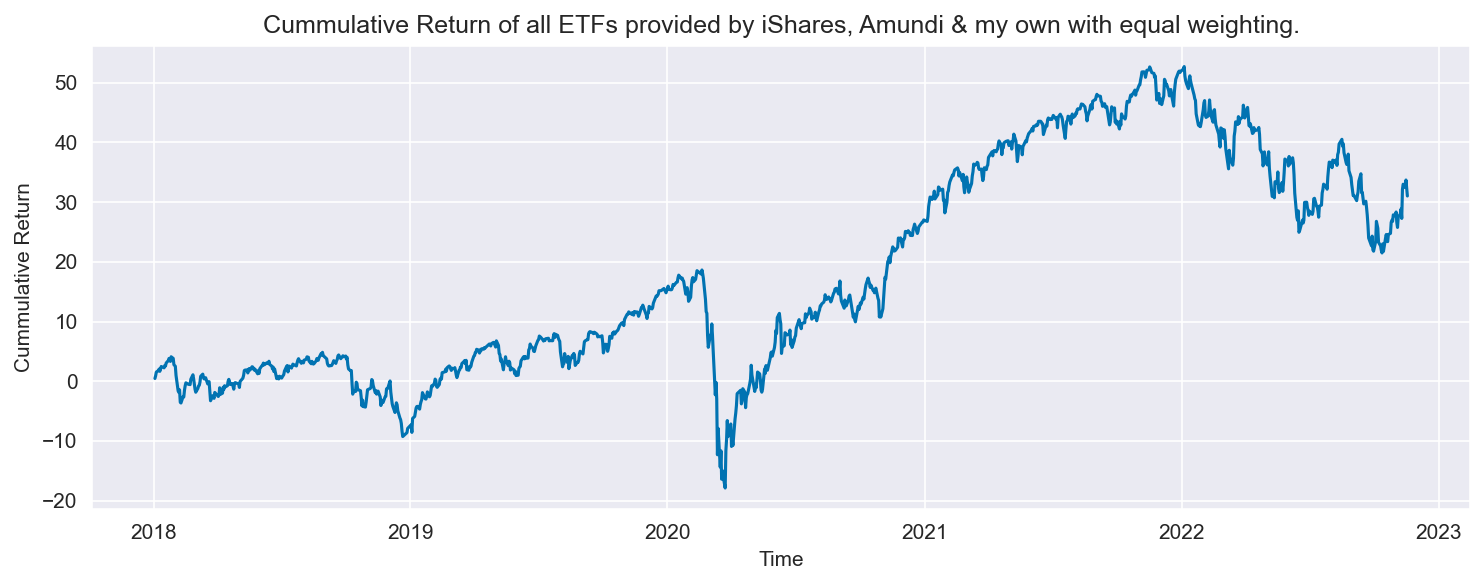

In [39]:
# compute equal weighting
N = len(all_data_returns.columns)
equal_weights = N * [1/N]

# compute the cummulative returns
equal_returns = np.dot(equal_weights,all_data_returns.transpose())
cum_equal_returns =   (1 + equal_returns).cumprod() - 1
cum_equal_returns_perc = pd.Series(100 * cum_equal_returns)
cum_equal_returns_perc.index = all_data_returns.index

# plot them
sns.set_style('darkgrid')
sns.set_palette('colorblind')

plt.figure(figsize=(10,4), dpi=150)
plt.plot(cum_equal_returns_perc)
plt.xlabel('Time')
plt.ylabel('Cummulative Return')
plt.title('Cummulative Return of all ETFs provided by iShares, Amundi & my own with equal weighting.')

plt.tight_layout()
plt.show();

Explanation Efficient Frontier:
The EF shows the set of optimal portfolios that offer the highest expected return for a given risk level or the lowest risk for a given level of expected return.

In [40]:
# mean-variance method with all data
mu = mean_historical_return(all_data)
S = CovarianceShrinkage(all_data).ledoit_wolf()

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'IVV': 0.14907, 'IEFA': 0.0, 'AGG': 0.0, 'IJR': 0.0, 'SPX.MI': 0.85093, 'MEUD.PA': 0.0, 'URTH': 0.0, 'AEEM.PA': 0.0}


In [41]:
ef.portfolio_performance(verbose=True)

Expected annual return: 11.6%
Annual volatility: 18.1%
Sharpe Ratio: 0.53


(0.11591881135771792, 0.18057687161783267, 0.5311799373771273)

<AxesSubplot:xlabel='Volatility', ylabel='Return'>

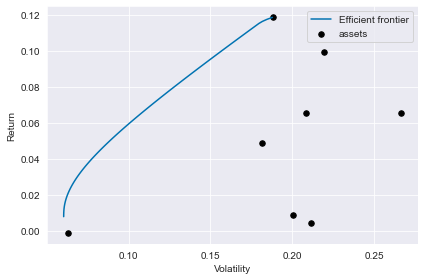

In [42]:
ef_plot = EfficientFrontier(mu, S)
plotting.plot_efficient_frontier(ef_plot)

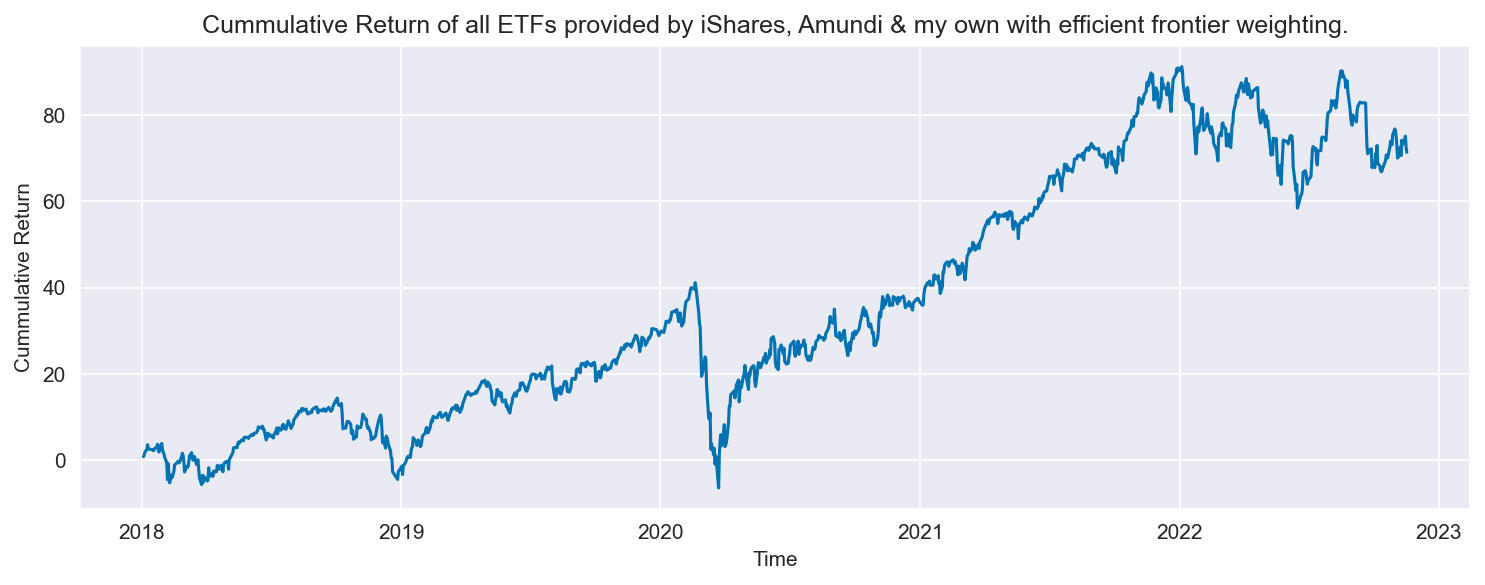

In [43]:
# plot development with the efficient frontier weighting
ef_weights = [0.01692, 0.0, 0.0, 0.0, 0.98308, 0.0, 0.0,  0.0]

ef_returns = np.dot(ef_weights, all_data_returns.transpose())
cum_ef_returns =   (1 + ef_returns).cumprod() - 1
cum_ef_returns_perc = pd.Series(100 * cum_ef_returns)
cum_ef_returns_perc.index = all_data_returns.index

# plot them
sns.set_style('darkgrid')
sns.set_palette('colorblind')

plt.figure(figsize=(10,4), dpi=150)
plt.plot(cum_ef_returns_perc)
plt.xlabel('Time')
plt.ylabel('Cummulative Return')
plt.title('Cummulative Return of all ETFs provided by iShares, Amundi & my own with efficient frontier weighting.')

plt.tight_layout()
plt.show();

<AxesSubplot:xlabel='Volatility', ylabel='Return'>

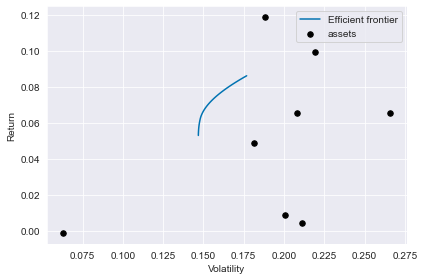

In [44]:
# constraints: the weighting of asset 1 must be greater or equal to 20%, weighting of asset 3 must be equal to 15%
# and the weighting of asset 4 and 5 must be added to be smaller or equal than 10%
ef_plot_c1 = EfficientFrontier(mu, S)
ef_plot_c1.add_constraint(lambda w: w[0] >= 0.2)
ef_plot_c1.add_constraint(lambda w: w[2] == 0.15)
ef_plot_c1.add_constraint(lambda w: w[3] + w[4] <= 0.10)

plotting.plot_efficient_frontier(ef_plot_c1)

In [45]:
# mean-variance method my own
mu2 = mean_historical_return(antons_data)
S2 = CovarianceShrinkage(antons_data).ledoit_wolf()

ef2 = EfficientFrontier(mu2, S2)
weights2 = ef2.max_sharpe()
cleaned_weights2 = ef2.clean_weights()
print(dict(cleaned_weights2))

antons_data_returns = antons_data.pct_change().dropna()
ef_weights2 = [0.0, 0.0, 0.83616, 0.16384]

ef2_returns = np.dot(ef_weights2, antons_data_returns.transpose())
cum_ef2_returns =   (1 + ef2_returns).cumprod() - 1
cum_ef2_returns_perc = pd.Series(100 * cum_ef2_returns)
cum_ef2_returns_perc.index = antons_data_returns.index

{'URTH': 0.0, 'AEEM.PA': 0.0, 'IUHE.AS': 0.83355, 'ICOM.L': 0.16645}


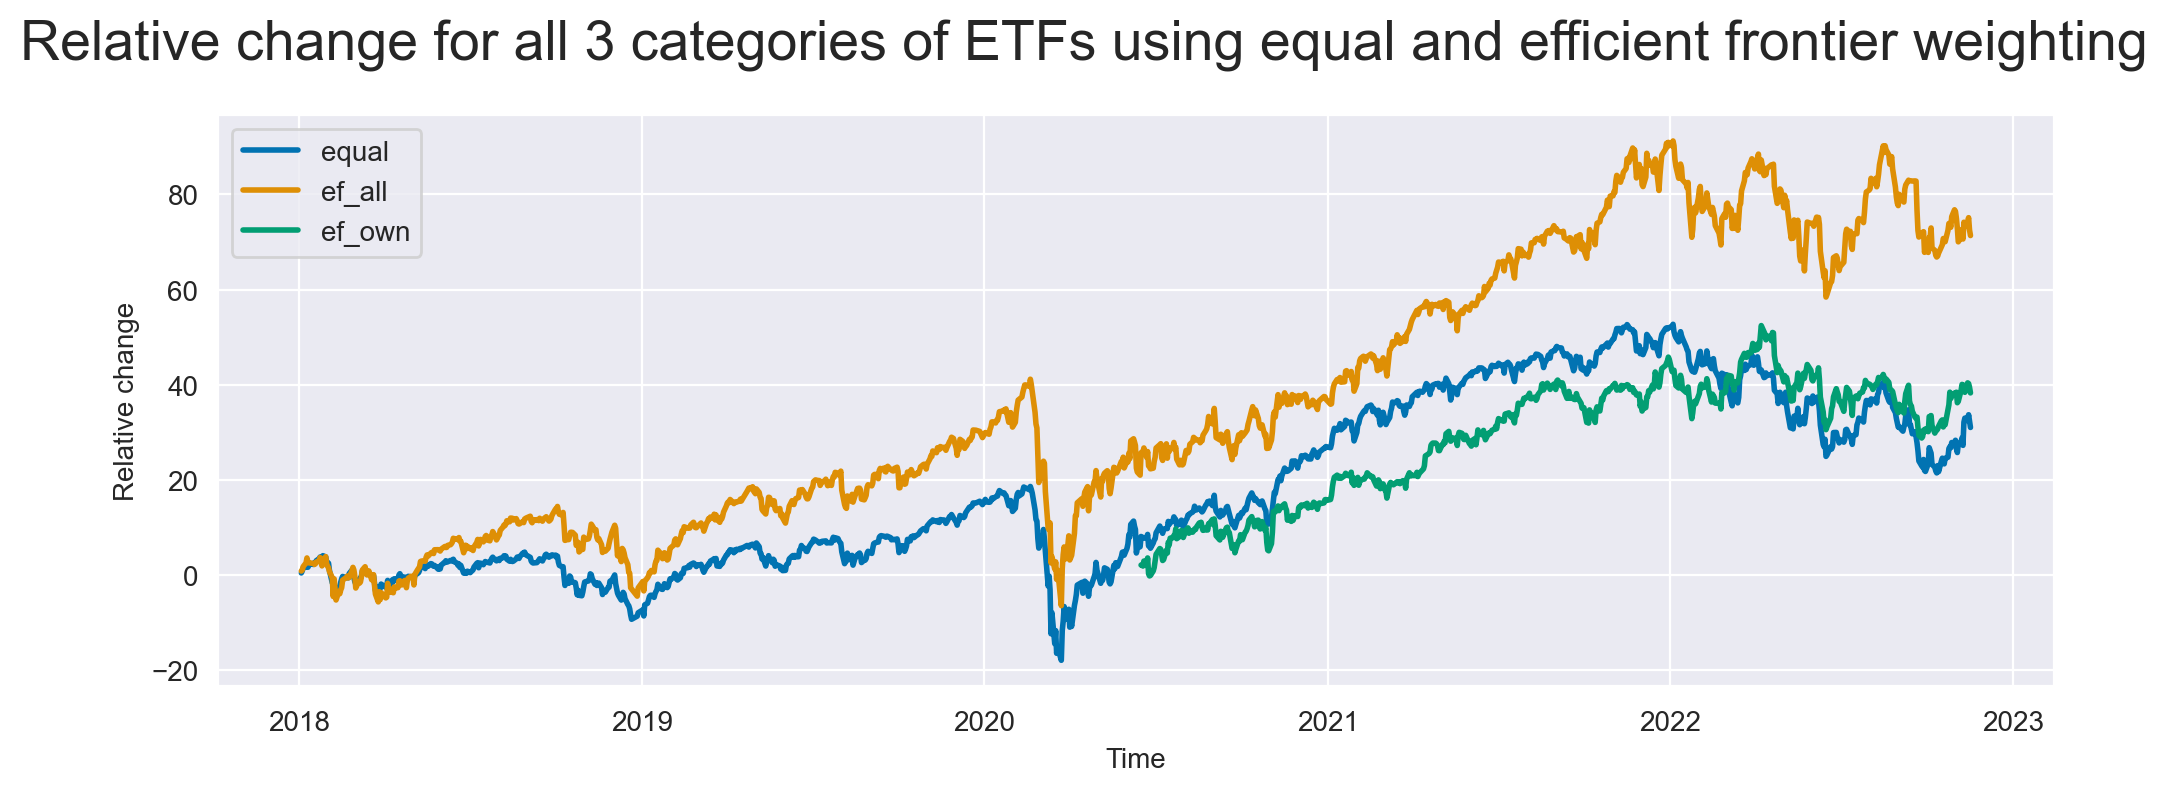

In [46]:
sns.set_style('darkgrid')
sns.set_palette('colorblind')

fig, ax = plt.subplots(figsize=(10,4), dpi=200)

ax.plot(cum_equal_returns_perc, label="equal", lw=2)
ax.plot(cum_ef_returns_perc, label="ef_all", lw=2)
ax.plot(cum_ef2_returns_perc, label="ef_own",lw=2)

ax.set_xlabel('Time')
ax.set_ylabel('Relative change')

fig.suptitle('Relative change for all 3 categories of ETFs using equal and efficient frontier weighting', fontsize=20)

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y"))
ax.tick_params(axis="x", which="major",rotation=0, pad=5)

ax.legend(loc ='upper left')

plt.tight_layout()
plt.show();

Conslusion Portfolio Optimization: it is clearly shown, that my past decisions lead to missing opportunities or missing growth, resp. Therefore, my choices were rather bad. 